# Basic Convolutional Neural Network (CNN)
We will train and evaluate a CNN on the Fashion MNIST dataset. It consists of 70.000 grayscale images of 28x28 pixels each, and there are 10 classes.

## Setup

In [1]:
# Common imports
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load the data
Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# Show the size and dimension of the dataset.
X_train_full.shape

(60000, 28, 28)

In [4]:
# Each pixel intensity is represented as a byte (0 to 255).
X_train_full.dtype

dtype('uint8')

In [5]:
# Reshape training and test sets so that a single color channel is added as the fourth dimension (not necessary)
X_train_full = np.reshape(X_train_full, (-1,28,28,1))
X_test = np.reshape(X_test, (-1,28,28,1))
X_train_full.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [6]:
# Split the full training set into a validation set and a (smaller) training set.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test

In [7]:
# The labels are the class IDs (represented as uint8), from 0 to 9.
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

##Data preparation using Keras Preprocessing layers

In [9]:
IMG_SIZE = 28

data_preparation = tf.keras.Sequential([
    # Resize the images. Useful if not all images have the same size or if
    # you want to reduce image size.
    keras.layers.Resizing(height=IMG_SIZE, width=IMG_SIZE),

    # Normalization:
    keras.layers.Rescaling(1./255),

    # Image Augmentation:
    # Note that data augmentation is inactive at test time so input images will only
    # be augmented during calls to Model.fit (not Model.evaluate or Model.predict).

    # Random rotation
    #keras.layers.RandomRotation(0.1),

    # Random vertical and horizontal shifts
    #keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),

    # All-in-one image augmentation layer (recommended as can be seen in the documentation)
    keras.layers.RandAugment(value_range=(0, 1), num_ops=2, factor=0.5)
])

## Create a CNN

In [10]:
model = keras.models.Sequential([
    keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),

    # Calling the data_preparation function defined above
    data_preparation,

    # Define a CNN
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax')
])

### Show information about the model

In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the model
You must at least specify the loss function and the optimizer to use. You can also specify a list of additional metrics to use during training and evaluation.

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(momentum=0.9),
              metrics=["accuracy"])

## Train the model

In [13]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.5032 - loss: 1.2963 - val_accuracy: 0.8312 - val_loss: 0.4272
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8023 - loss: 0.5514 - val_accuracy: 0.8690 - val_loss: 0.3538
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8451 - loss: 0.4472 - val_accuracy: 0.8818 - val_loss: 0.3077
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8652 - loss: 0.3904 - val_accuracy: 0.8944 - val_loss: 0.2877
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8779 - loss: 0.3508 - val_accuracy: 0.8984 - val_loss: 0.2826
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8888 - loss: 0.3281 - val_accuracy: 0.9034 - val_loss: 0.2744
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8971 - loss: 0.3011 - val_accuracy: 0.9064 - val_loss: 0.2662
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9025 -

In [14]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

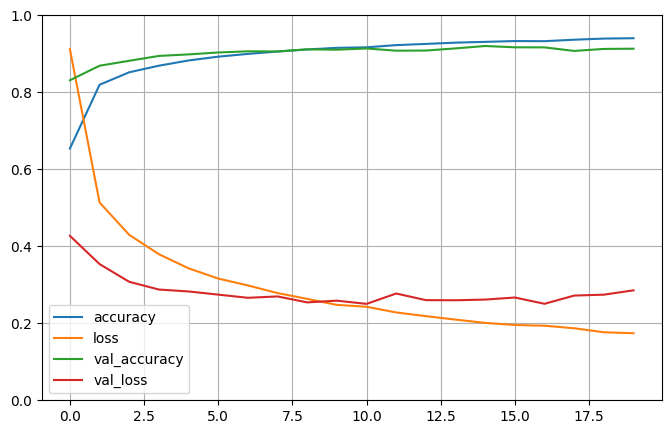

In [15]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with
# the validation curves).

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluate the model.

In [16]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9008 - loss: 0.3409


[0.33180657029151917, 0.9063000082969666]